# ETH Price Forecasting using ARIMA

Refer SARIMA notebook for understanding of the process. 

<a href = https://github.com/santhoshetty/Liquor-Sales-Forecast> Liquor Sales Forecast. </a>

In [1]:
# Import All Necessary Packages
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

# Remote Data Access
import pandas_datareader.data as web
import datetime
# reference: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from statsmodels.graphics.api import qqplot

import itertools
import warnings

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [2]:
# Examine the patterns of ACF and PACF (along with the time series plot and histogram)

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [3]:
# Step 1
# Read in liquor sales data. Change index of column to minutes
crypto = pd.read_csv('crypto_BTC-ETH.csv', header=0, index_col=0, parse_dates=[0])

n_forecast = 4
n_train = crypto.shape[0]-n_forecast

crypto_train = crypto.iloc[:n_train]['Value']
crypto_valid = crypto.iloc[n_train:]['Value']
print(crypto_train.shape)
print(crypto_valid.shape)
print("Training Series:", "\n", crypto_train.tail(), "\n")
print("Validation Series:", "\n", crypto_valid.head())

(1724,)
(4,)
Training Series: 
 Period
2041-12-07   0.07937
2041-12-12   0.07950
2041-12-17   0.07957
2041-12-22   0.07988
2041-12-27   0.07967
Name: Value, dtype: float64 

Validation Series: 
 Period
2042-01-01   0.07961
2042-01-06   0.07960
2042-01-11   0.07961
2042-01-16   0.07960
Name: Value, dtype: float64


(<matplotlib.axes._subplots.AxesSubplot at 0x1cb775260f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cb795cb128>)

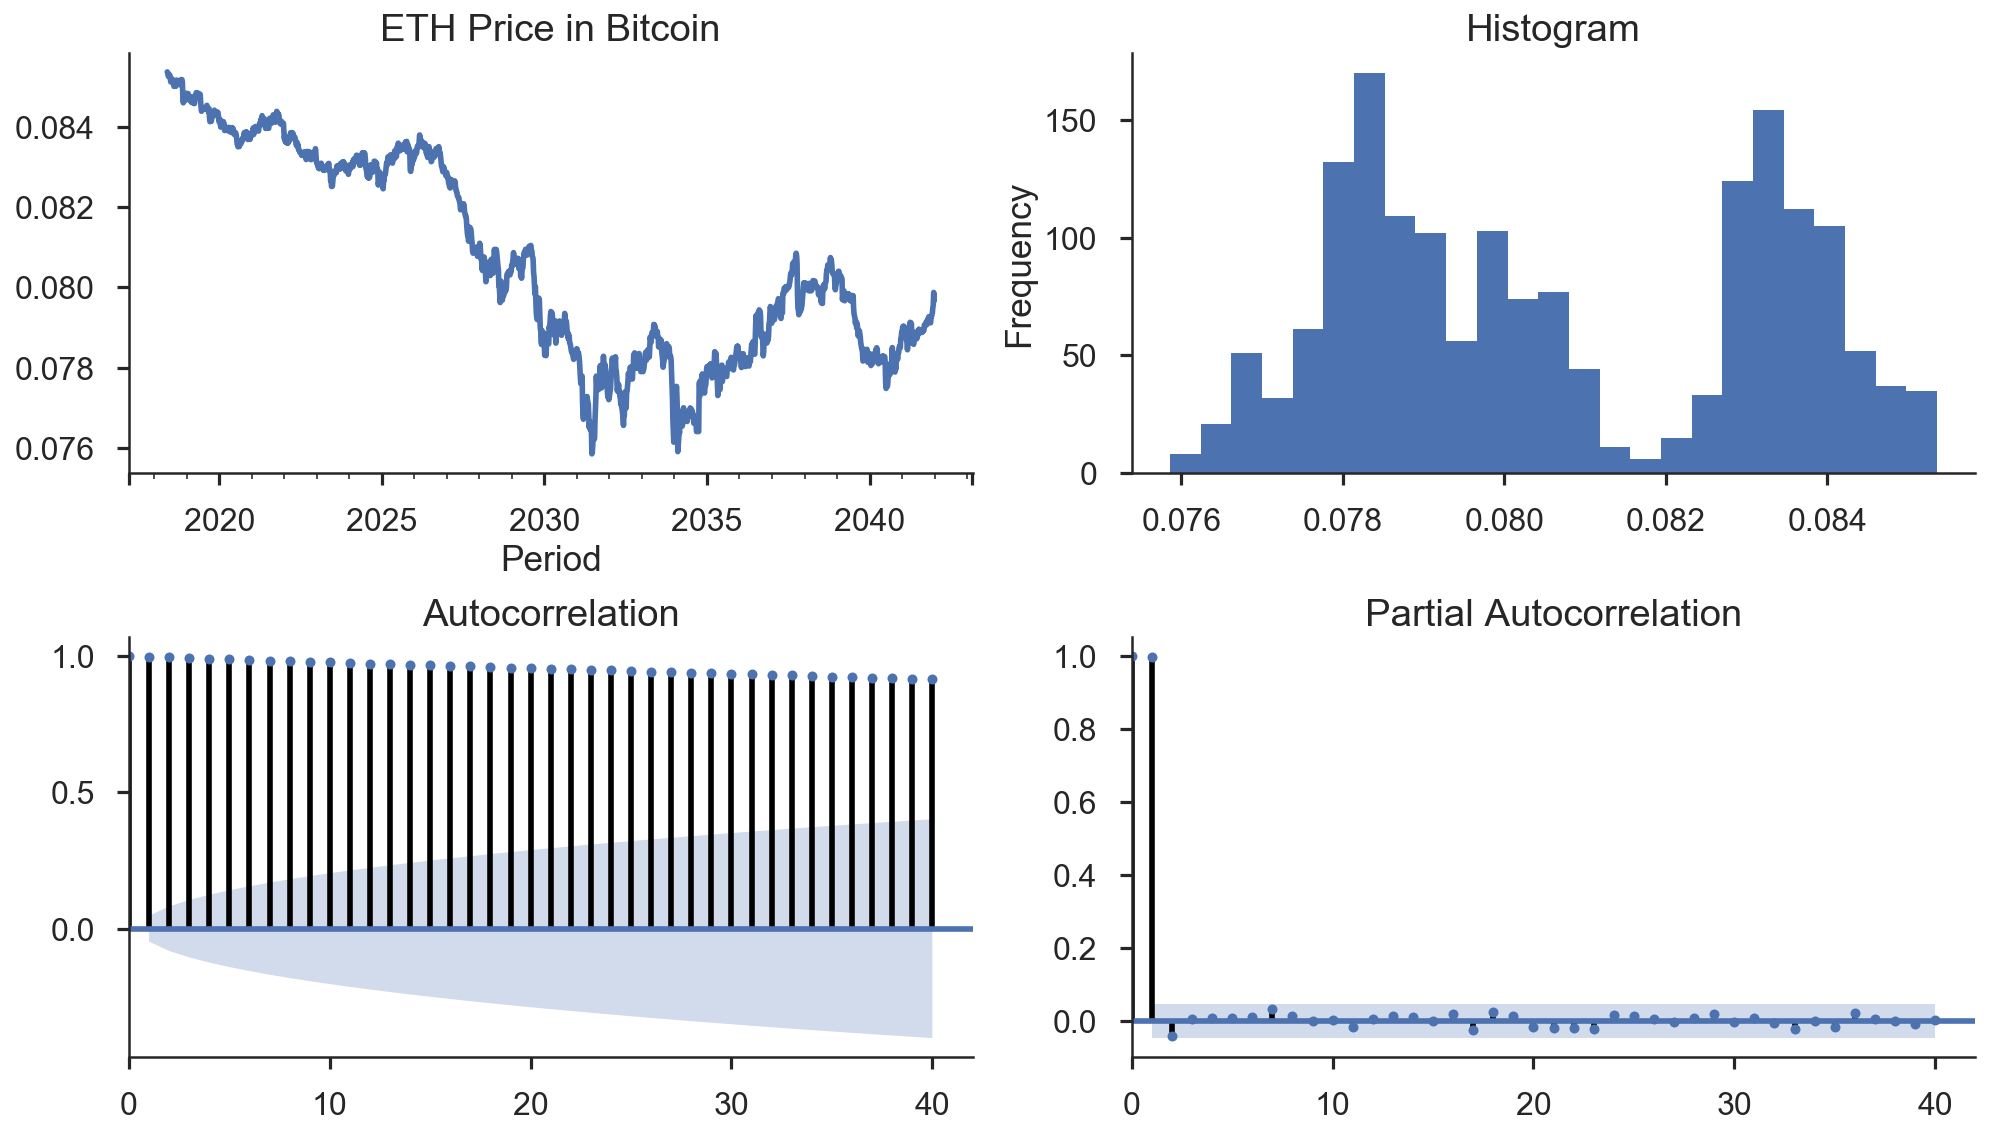

In [4]:
tsplot(crypto_train, title = 'ETH Price in Bitcoin', lags = 40)

In [5]:
def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series.
    
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput

In [6]:
test_stationarity(crypto_train)

Test Statistic                  -1.73566
p-value                          0.41284
#Lags Used                      25.00000
Number of Observations Used   1698.00000
Critical Value (1%)             -3.43421
Critical Value (5%)             -2.86324
Critical Value (10%)            -2.56768
dtype: float64

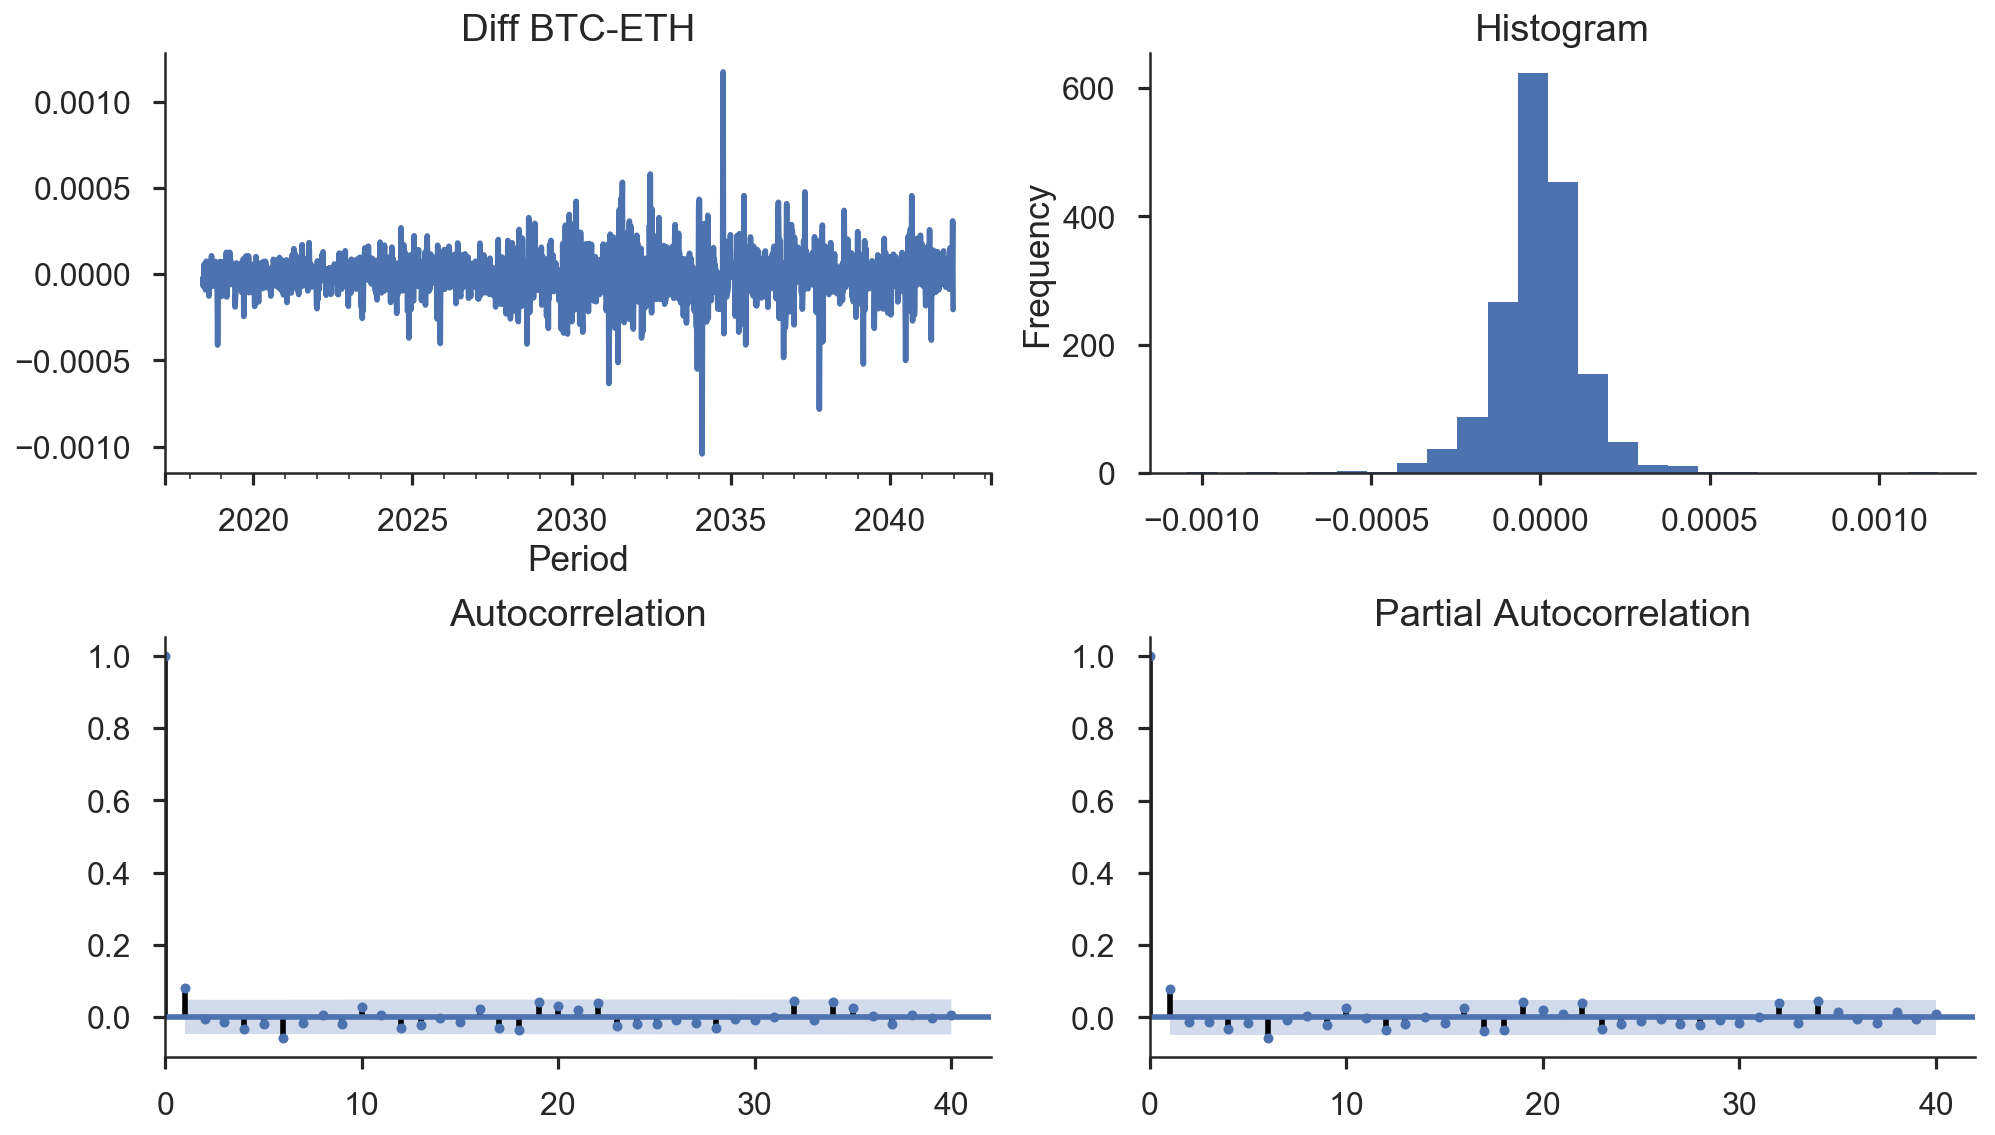

In [7]:
diff_crypto = crypto_train.diff().dropna()
tsplot(diff_crypto, title='Diff BTC-ETH', lags=40);

In [8]:
test_stationarity(diff_crypto)

Test Statistic                  -8.37279
p-value                          0.00000
#Lags Used                      25.00000
Number of Observations Used   1697.00000
Critical Value (1%)             -3.43421
Critical Value (5%)             -2.86324
Critical Value (10%)            -2.56768
dtype: float64

In [9]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)
def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

In [10]:
# Original Source: PyData 2016
def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': het_stat,
            'het_p': het_p,
            'norm_method': norm_method,
            'norm_stat': norm_stat,
            'norm_p': norm_p,
            'skew': skew,
            'kurtosis': kurtosis,
            'sercor_method': sercor_method,
            'sercor_stat': sercor_stat,
            'sercor_p': sercor_p,
            'dw_stat': dw_stat,
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

In [11]:
# Original Source: PyData 2016
def model_gridsearch(ts,
                     p_min,
                     d_min,
                     q_min,
                     p_max,
                     d_max,
                     q_max,
                     sP_min,
                     sD_min,
                     sQ_min,
                     sP_max,
                     sD_max,
                     sQ_max,
                     trends,
                     s=None,
                     enforce_stationarity=True,
                     enforce_invertibility=True,
                     simple_differencing=False,
                     plot_diagnostics=False,
                     verbose=False,
                     filter_warnings=True,
                    ):
    '''Run grid search of SARIMAX models and save results.
    '''
    
    cols = ['p', 'd', 'q', 'sP', 'sD', 'sQ', 's', 'trend',
            'enforce_stationarity', 'enforce_invertibility', 'simple_differencing',
            'aic', 'bic',
            'het_p', 'norm_p', 'sercor_p', 'dw_stat',
            'arroots_gt_1', 'maroots_gt_1',
            'datetime_run']

    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)

    # # Initialize a DataFrame to store the results
    # results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
    #                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

    mod_num=0
    for trend,p,d,q,sP,sD,sQ in itertools.product(trends,
                                                  range(p_min,p_max+1),
                                                  range(d_min,d_max+1),
                                                  range(q_min,q_max+1),
                                                  range(sP_min,sP_max+1),
                                                  range(sD_min,sD_max+1),
                                                  range(sQ_min,sQ_max+1),
                                                  ):
        # initialize to store results for this parameter set
        this_model = pd.DataFrame(index=[mod_num], columns=cols)

        if p==0 and d==0 and q==0:
            continue

        try:
            model = sm.tsa.SARIMAX(ts,
                                   trend=trend,
                                   order=(p, d, q),
                                   seasonal_order=(sP, sD, sQ, s),
                                   enforce_stationarity=enforce_stationarity,
                                   enforce_invertibility=enforce_invertibility,
                                   simple_differencing=simple_differencing,
                                  )
            
            if filter_warnings is True:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model_results = model.fit(disp=0)
            else:
                model_results = model.fit()

            if verbose:
                print(model_results.summary())

            if plot_diagnostics:
                model_results.plot_diagnostics();

            stat = model_resid_stats(model_results,
                                     verbose=verbose)

            this_model.loc[mod_num, 'p'] = p
            this_model.loc[mod_num, 'd'] = d
            this_model.loc[mod_num, 'q'] = q
            this_model.loc[mod_num, 'sP'] = sP
            this_model.loc[mod_num, 'sD'] = sD
            this_model.loc[mod_num, 'sQ'] = sQ
            this_model.loc[mod_num, 's'] = s
            this_model.loc[mod_num, 'trend'] = trend
            this_model.loc[mod_num, 'enforce_stationarity'] = enforce_stationarity
            this_model.loc[mod_num, 'enforce_invertibility'] = enforce_invertibility
            this_model.loc[mod_num, 'simple_differencing'] = simple_differencing

            this_model.loc[mod_num, 'aic'] = model_results.aic
            this_model.loc[mod_num, 'bic'] = model_results.bic
            
            pred_begin = crypto_train.index[model_results.loglikelihood_burn]
            pred_end = crypto_valid.index[-1]
            pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                                end=pred_end.strftime('%Y-%m-%d'))
            pred_mean = pred.predicted_mean
            rmse = get_rmse(crypto_valid[-4], pred_mean[-4])
            mape = get_mape(crypto_valid[-4], pred_mean[-4])
            
            this_model.loc[mod_num, 'mape'] = mape
            this_model.loc[mod_num, 'rmse'] = rmse
            # this_model.loc[mod_num, 'het_method'] = stat['het_method']
            # this_model.loc[mod_num, 'het_stat'] = stat['het_stat']
            this_model.loc[mod_num, 'het_p'] = stat['het_p']
            # this_model.loc[mod_num, 'norm_method'] = stat['norm_method']
            # this_model.loc[mod_num, 'norm_stat'] = stat['norm_stat']
            this_model.loc[mod_num, 'norm_p'] = stat['norm_p']
            # this_model.loc[mod_num, 'skew'] = stat['skew']
            # this_model.loc[mod_num, 'kurtosis'] = stat['kurtosis']
            # this_model.loc[mod_num, 'sercor_method'] = stat['sercor_method']
            # this_model.loc[mod_num, 'sercor_stat'] = stat['sercor_stat']
            this_model.loc[mod_num, 'sercor_p'] = stat['sercor_p']
            this_model.loc[mod_num, 'dw_stat'] = stat['dw_stat']
            this_model.loc[mod_num, 'arroots_gt_1'] = stat['arroots_outside_unit_circle']
            this_model.loc[mod_num, 'maroots_gt_1'] = stat['maroots_outside_unit_circle']

            this_model.loc[mod_num, 'datetime_run'] = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')

            df_results = df_results.append(this_model)
            mod_num+=1
        except:
            continue
    return df_results

In [12]:
# Original Source: PyData 2016
# run model grid search
p_min = 0
d_min = 0
q_min = 0
p_max = 2
d_max = 2
q_max = 2

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 0
sD_max = 0
sQ_max = 0

s=0

# trends=['n', 'c']
trends=['n']

enforce_stationarity=True
enforce_invertibility=True
simple_differencing=False

plot_diagnostics=False

verbose=False

df_results = model_gridsearch(crypto_train,
                              p_min,
                              d_min,
                              q_min,
                              p_max,
                              d_max,
                              q_max,
                              sP_min,
                              sD_min,
                              sQ_min,
                              sP_max,
                              sD_max,
                              sQ_max,
                              trends,
                              s=s,
                              enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility,
                              simple_differencing=simple_differencing,
                              plot_diagnostics=plot_diagnostics,
                              verbose=verbose,
                              )

In [13]:
df_results.sort_values(by='mape').head(10)

,aic,arroots_gt_1,bic,d,datetime_run,dw_stat,enforce_invertibility,enforce_stationarity,het_p,mape,maroots_gt_1,norm_p,p,q,rmse,s,sD,sP,sQ,sercor_p,simple_differencing,trend
14,-25947.05597,True,-25925.24636,1,2018-05-27 00:00:00,2.00182,True,True,0.00000,0.03906,True,0,2,1,0.00003,0,0,0,0,0.72075,False,n
13,-25919.59188,True,-25897.78227,0,2018-05-27 00:00:00,1.97866,True,True,0.00000,0.04178,True,0,2,1,0.00003,0,0,0,0,0.65879,False,n
5,-25919.49329,True,-25897.68368,0,2018-05-27 00:00:00,1.97764,True,True,0.00000,0.04213,True,0,1,2,0.00003,0,0,0,0,0.65892,False,n
8,-25941.31320,True,-25919.50359,1,2018-05-27 00:00:00,1.99552,True,True,0.00000,0.04229,True,0,1,2,0.00003,0,0,0,0,0.62904,False,n
4,-25921.97057,True,-25905.61336,0,2018-05-27 00:00:00,1.98001,True,True,0.00000,0.04440,True,0,1,1,0.00004,0,0,0,0,0.65767,False,n
1,-25946.03708,True,-25929.67987,1,2018-05-27 00:00:00,1.99415,True,True,0.00000,0.04571,True,0,0,2,0.00004,0,0,0,0,0.56427,False,n
7,-25946.04057,True,-25929.68337,1,2018-05-27 00:00:00,1.99585,True,True,0.00000,0.04675,True,0,1,1,0.00004,0,0,0,0,0.56634,False,n
12,-25921.71457,True,-25905.35737,0,2018-05-27 00:00:00,1.97881,True,True,0.00000,0.04700,True,0,2,0,0.00004,0,0,0,0,0.65070,False,n
0,-25948.00105,True,-25937.09624,1,2018-05-27 00:00:00,1.99651,True,True,0.00000,0.04829,True,0,0,1,0.00004,0,0,0,0,0.56598,False,n
6,-25947.86360,True,-25936.95879,1,2018-05-27 00:00:00,1.99651,True,True,0.00000,0.05076,True,0,1,0,0.00004,0,0,0,0,0.56002,False,n


In [20]:
mod = sm.tsa.statespace.SARIMAX(crypto_train, order=(2,1,1))
sarima_fit = mod.fit()
print(sarima_fit.summary())

                           Statespace Model Results                           
Dep. Variable:                  Value   No. Observations:                 1724
Model:               SARIMAX(2, 1, 1)   Log Likelihood               12977.528
Date:                Sun, 27 May 2018   AIC                         -25947.056
Time:                        10:47:25   BIC                         -25925.246
Sample:                    05-27-2018   HQIC                        -25938.988
                         - 12-27-2041                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0261      0.002    448.079      0.000       1.022       1.031
ar.L2         -0.0895      0.002    -40.662      0.000      -0.094      -0.085
ma.L1         -0.9446      0.002   -411.982      0.0

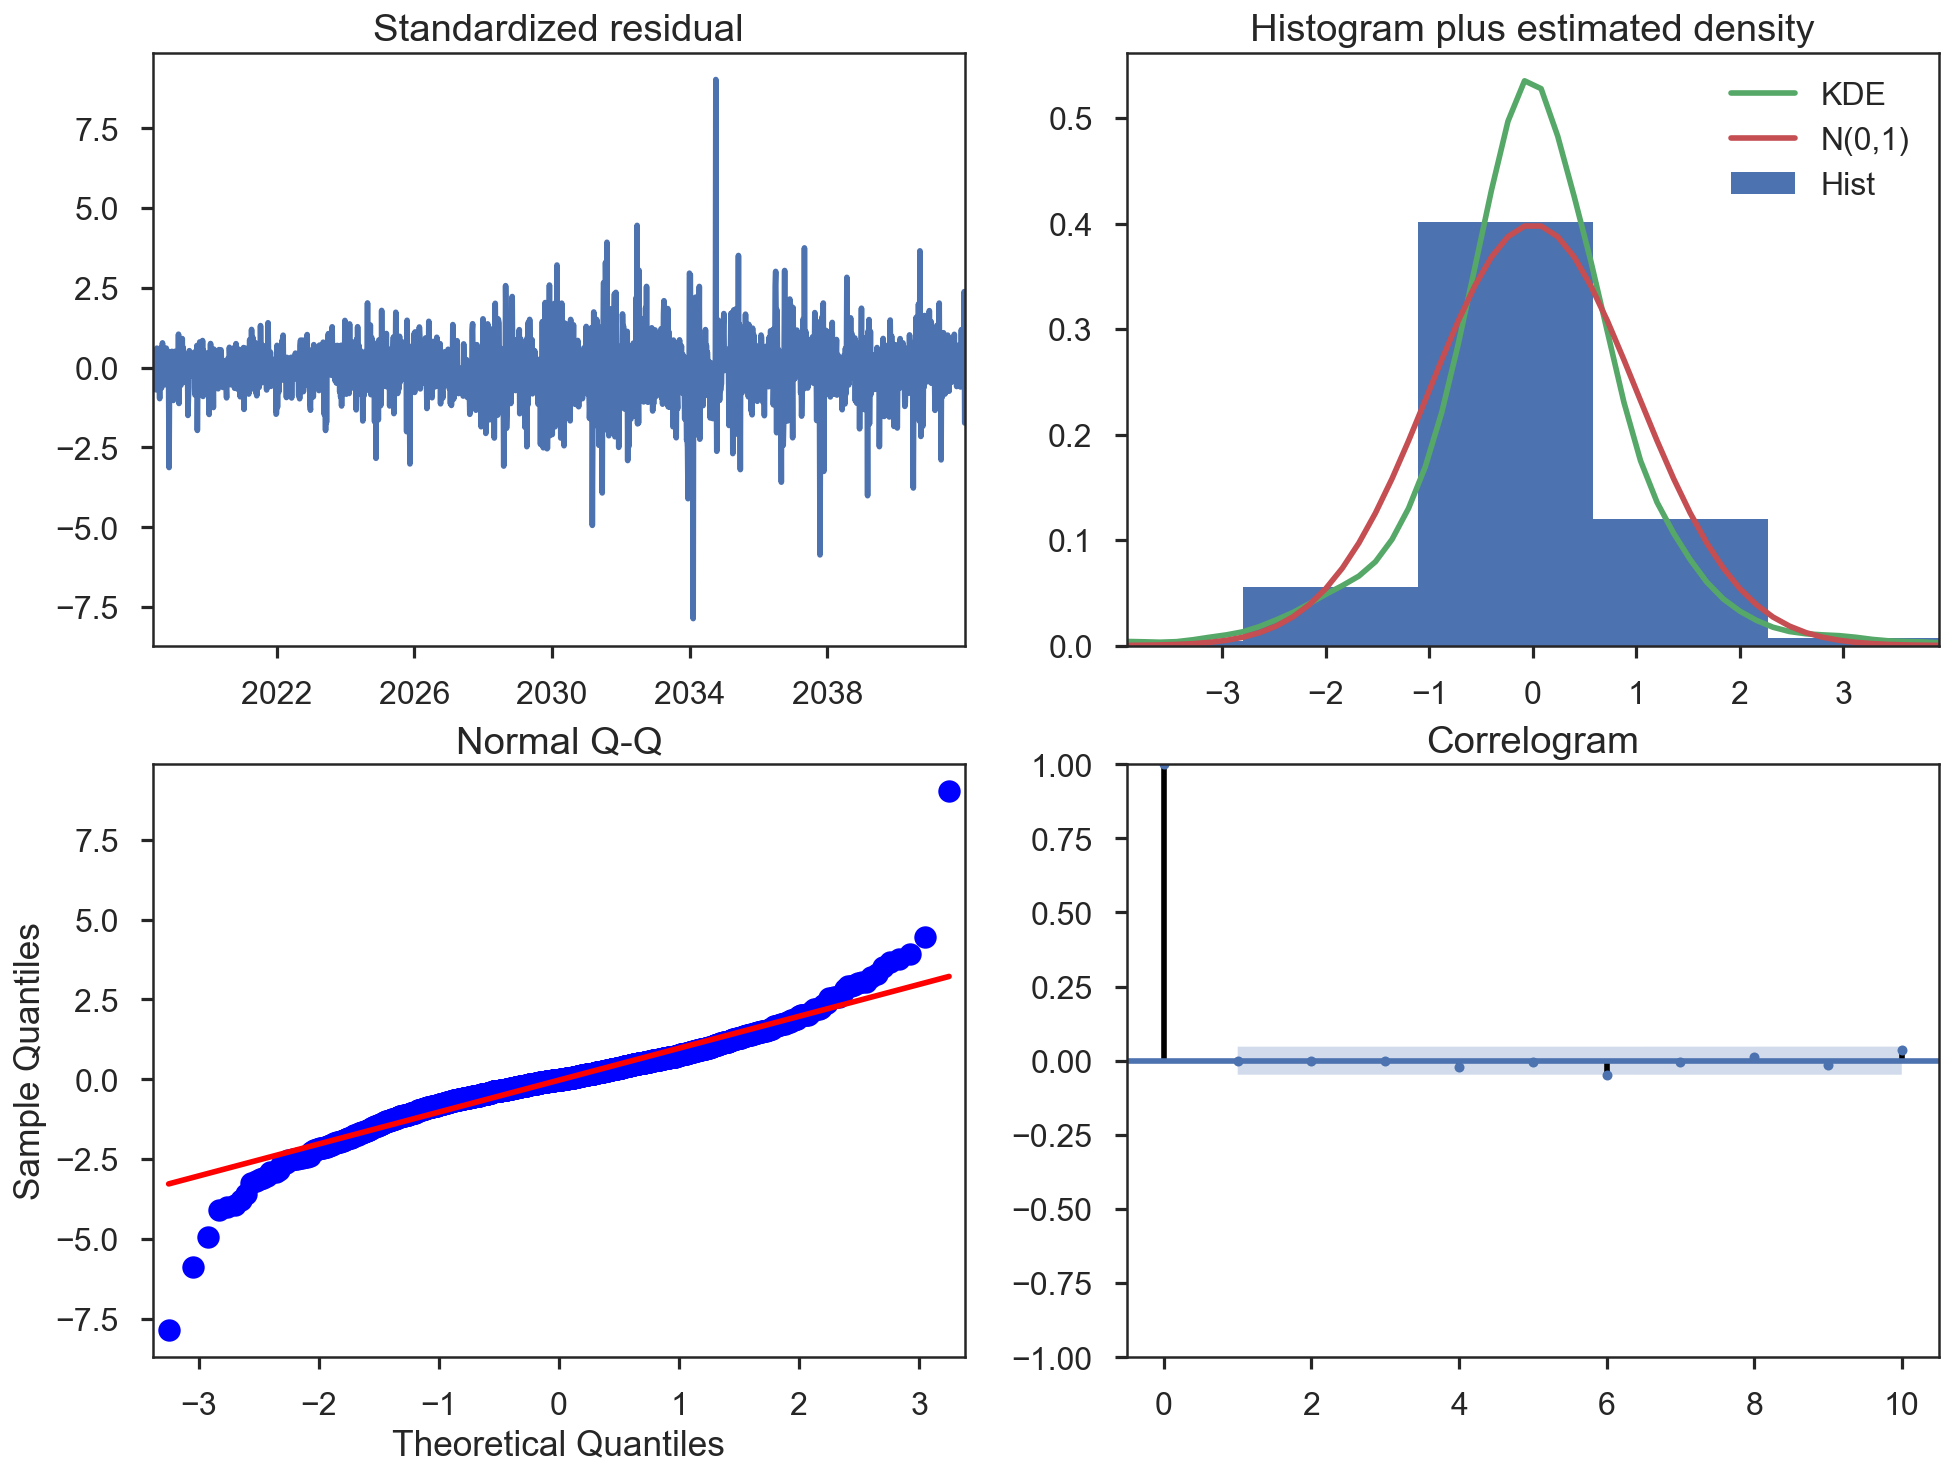

In [21]:
sarima_fit.plot_diagnostics(figsize=(16, 12));

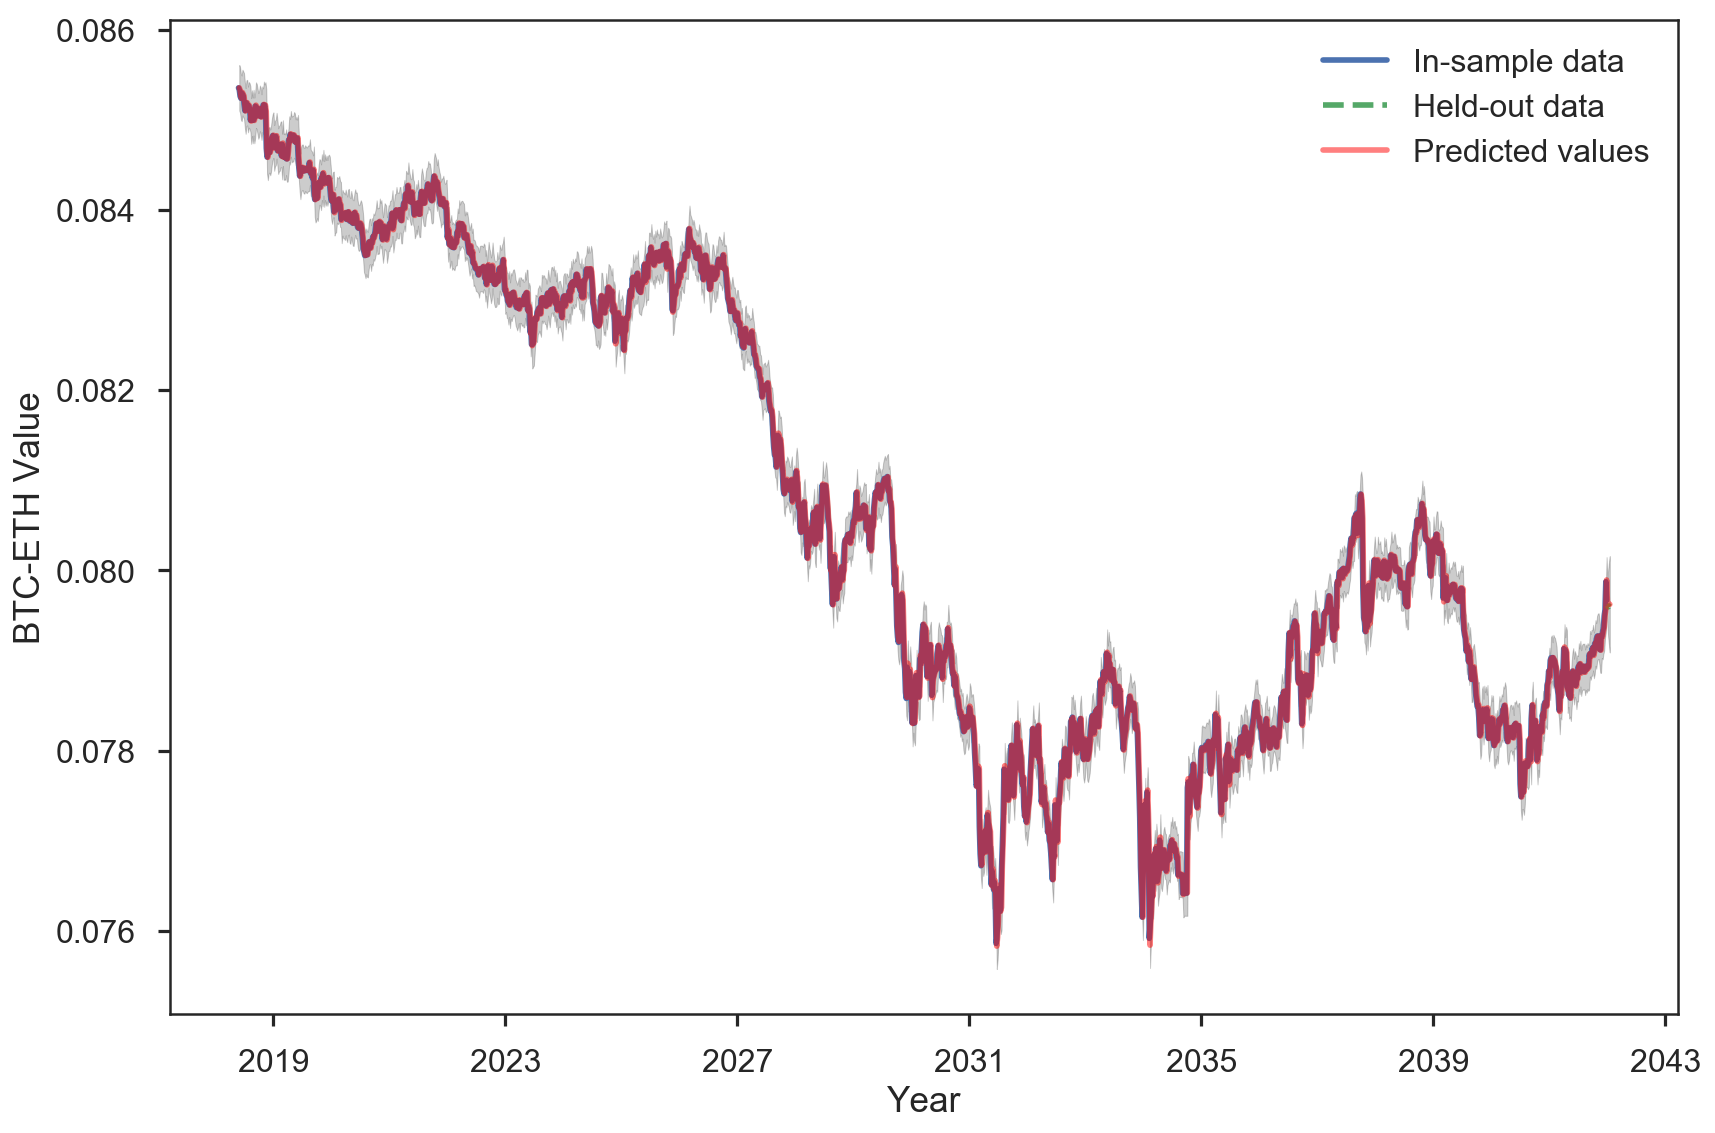

In [22]:
# Step 5: Do a 3-step ahead forecast
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(crypto_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(crypto_valid, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = crypto_train.index[sarima_fit.loglikelihood_burn]
pred_end = crypto_valid.index[-1]
pred = sarima_fit.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.5, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("BTC-ETH Value")
ax1.legend(loc='best');
fig.tight_layout();
## Discuss the results.  How does your forecast look?

In [23]:
mape = get_mape(crypto_valid[-4], pred_mean[-4])
print("MAPE: ", mape)

MAPE:  0.03905854490648429


In [18]:
rmse = get_rmse(crypto_valid[-4], pred_mean[-4])
print("RMSE: ", rmse)

RMSE:  8.305263971512822e-05


In [19]:
pred_mean[-10:]

2041-12-02   0.07931
2041-12-07   0.07940
2041-12-12   0.07940
2041-12-17   0.07958
2041-12-22   0.07964
2041-12-27   0.08006
2042-01-01   0.07970
2042-01-06   0.07975
2042-01-11   0.07971
2042-01-16   0.07972
Freq: 5D, dtype: float64

A 0.039% Error on the BTC-ETH price forecasted is obtained.